In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nba_database.db to nba_database (1).db


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

conn = sqlite3.connect('nba_database.db')

### This is how you should write your query

In [ ]:
# write your query
query = '''SELECT * FROM player_seasons
WHERE team_id = 4 and season_id = 3
LIMIT 5;'''
df = pd.read_sql_query(query, conn)
print(df.to_string(index=False))

 player_id  team_id  season_id  G GS   MP  FG  FGA  FG%  3P  3PA  3P%  2P  2PA  2P% eFG%  FT FTA  FT% ORB DRB TRB AST STL BLK TOV  PF  PTS      Salary Exp
       154        4          3 63 63 35.3 7.8 18.9 .415 2.6  8.0 .327 5.2 10.8 .480 .484 2.8 3.5 .809 0.8 3.3 4.1 5.1 1.2 0.3 2.1 1.9 21.1 $21,486,316   3
       246        4          3 36 36 35.2 8.2 20.0 .411 4.0 10.6 .376 4.2  9.4 .450 .510 2.8 3.4 .836 1.2 5.3 6.4 8.4 1.3 0.3 3.6 3.3 23.3  $8,623,920   4
       283        4          3 73 73 32.6 5.9 13.4 .444 2.0  5.9 .348 3.9  7.5 .518 .520 1.7 2.4 .730 1.0 3.9 4.9 2.4 0.9 1.1 1.5 2.6 15.7  $5,808,435   4
       286        4          3 48 40 32.3 7.4 17.1 .431 2.3  7.1 .319 5.1 10.0 .510 .497 3.3 4.3 .760 1.4 3.8 5.2 1.1 1.4 0.4 1.3 2.9 20.3        None   7
       145        4          3 50 50 31.5 5.5 11.6 .475 1.0  3.2 .325 4.5  8.4 .532 .520 2.6 3.2 .811 0.7 3.6 4.3 4.1 0.8 0.2 2.0 1.4 14.7 $30,075,000   9


table names:

In [ ]:
query = '''SELECT name FROM sqlite_master WHERE type='table';'''
df = pd.read_sql_query(query, conn)
print(df.to_string(index=False))

          name
       players
player_seasons
         teams
  team_seasons
 awards_season
        awards
       seasons
mvp_candidates


## Mahan

###Descriptive Statistics

#### Part1

In [ ]:
m_query_1 = '''SELECT
    s.season_label as Season,
    p.Player,
    p.Ht
FROM mvp_candidates m
JOIN Players p ON m.Player_id = p.id
JOIN seasons s on m.Season_id = s.id
WHERE m.Season_id BETWEEN 2 AND 6
'''

mvp_df = pd.read_sql_query(m_query_1, conn)
mvp_df

In [ ]:
def height_to_cm(height_str):
    feet, inches = map(int, height_str.split('-'))
    return feet * 30.48 + inches * 2.54

mvp_df['Height_cm'] = mvp_df['Ht'].apply(height_to_cm)
mvp_df

In [ ]:
mvp_df = mvp_df.groupby('Season')[['Height_cm']].mean()
mvp_df

In [ ]:
m_query_2 = '''SELECT
                  ps.player_id,
                  p.Player,
                  p.Ht,
                  s.season_label as Season,
                  ps.PTS,
                  ps.G
                FROM player_seasons ps
                JOIN players p on p.id = ps.player_id
                JOIN seasons s on s.id = ps.season_id'''

top_players_df = pd.read_sql_query(m_query_2, conn)
top_players_df = top_players_df.drop_duplicates(subset=['player_id', 'Season'], keep='first')
top_players_df = top_players_df[top_players_df['G'].apply(lambda x: str(x).replace('.', '').isdigit())]
top_players_df['Total PTS'] = top_players_df['PTS'].astype(float) * top_players_df['G'].astype(float)

top_players_df['Season Rank'] = top_players_df.groupby('Season')['Total PTS'].rank(method='dense', ascending=False)
top_players_df = top_players_df[top_players_df['Season Rank'] <= 10].sort_values(by=['Season', 'Season Rank'])
top_players_df = top_players_df[top_players_df['Season'].isin(['2023-24' ,'2022-23', '2021-22', '2020-21', '2019-20'])]
top_players_df['Height_cm'] = top_players_df['Ht'].apply(height_to_cm)
top_players_df = top_players_df.groupby('Season')[['Height_cm']].mean()
top_players_df

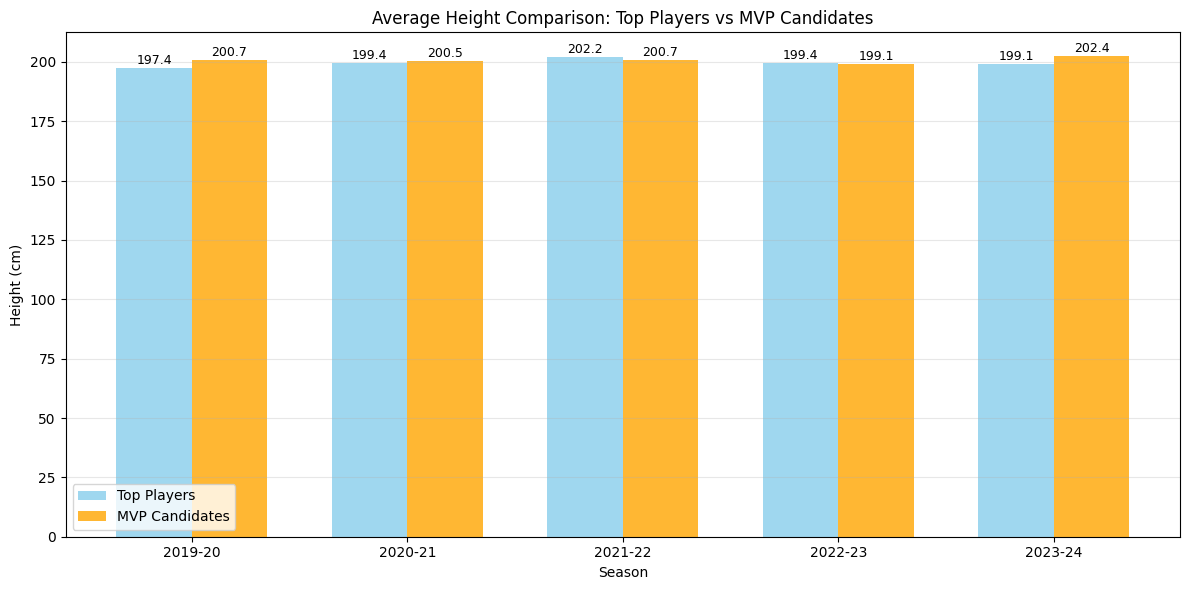

In [ ]:
seasons = top_players_df.index
x = np.arange(len(seasons))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, top_players_df['Height_cm'], width,
               label='Top Players', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, mvp_df['Height_cm'], width,
               label='MVP Candidates', color='orange', alpha=0.8)

ax.set_xlabel('Season')
ax.set_ylabel('Height (cm)')
ax.set_title('Average Height Comparison: Top Players vs MVP Candidates')
ax.set_xticks(x)
ax.set_xticklabels(seasons)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Part2

In [ ]:
m_query_3 = '''SELECT
                  ps.player_id,
                  p.Player,
                  s.season_label as Season,
                  p.Ht,
                  ps.Exp,
                  ps.PTS,
                  ps.G
                FROM player_seasons ps
                JOIN players p on p.id = ps.player_id
                JOIN seasons s on s.id = ps.season_id
                WHERE ps.Season_id BETWEEN 2 AND 3'''

top_15_players_df = pd.read_sql_query(m_query_3, conn)
top_15_players_df = top_15_players_df.drop_duplicates(subset=['player_id', 'Season'], keep='first')
top_15_players_df = top_15_players_df[top_15_players_df['Ht'].str.contains('-', na=False)]
top_15_players_df['Height(cm)'] = top_15_players_df['Ht'].apply(height_to_cm)
top_15_players_df = top_15_players_df[top_15_players_df['G'].apply(lambda x: str(x).replace('.', '').isdigit())]
top_15_players_df['Total PTS'] = top_15_players_df['PTS'].astype(float) * top_15_players_df['G'].astype(float)

top_15_players_df = top_15_players_df[top_15_players_df['Exp'] != 'R']

top_15_players_df['Season Rank'] = top_15_players_df.groupby('Season')['Total PTS'].rank(method='dense', ascending=False)
top_15_players_df = top_15_players_df[top_15_players_df['Season Rank'] <= 15].sort_values(by=['Season', 'Season Rank'])
top_15_players_df['Exp'] = top_15_players_df['Exp'].astype(float)
top_15_players_df = top_15_players_df.groupby('Season').agg({'Height(cm)': 'mean', 'Exp': 'mean'})
top_15_players_df

In [ ]:
m_query_4 = '''SELECT
                ps.player_id,
                p.player,
                s.season_label as Season,
                p.Ht,
                ps.Exp,
                t.team_name,
                s.[League Champion]
                FROM player_seasons as ps
                JOIN players p on p.id = ps.player_id
                JOIN seasons s on s.id = ps.season_id
                JOIN teams t on t.id = ps.team_id
                WHERE ps.Season_id BETWEEN 2 AND 3;'''

champion_teams_df = pd.read_sql_query(m_query_4, conn)
champion_teams_df = champion_teams_df.drop_duplicates(subset=['player_id', 'Season'], keep='first')
champion_teams_df = champion_teams_df[champion_teams_df['team_name'] == champion_teams_df['League Champion']]

champion_teams_df = champion_teams_df[champion_teams_df['Exp'] != 'R']
champion_teams_df = champion_teams_df[champion_teams_df['Ht'].str.contains('-', na=False)]
champion_teams_df['Height(cm)'] = champion_teams_df['Ht'].apply(height_to_cm)
champion_teams_df['Exp'] = champion_teams_df['Exp'].astype(float)

champion_teams_df = champion_teams_df.groupby('Season').agg({'Height(cm)': 'mean', 'Exp': 'mean'})
champion_teams_df


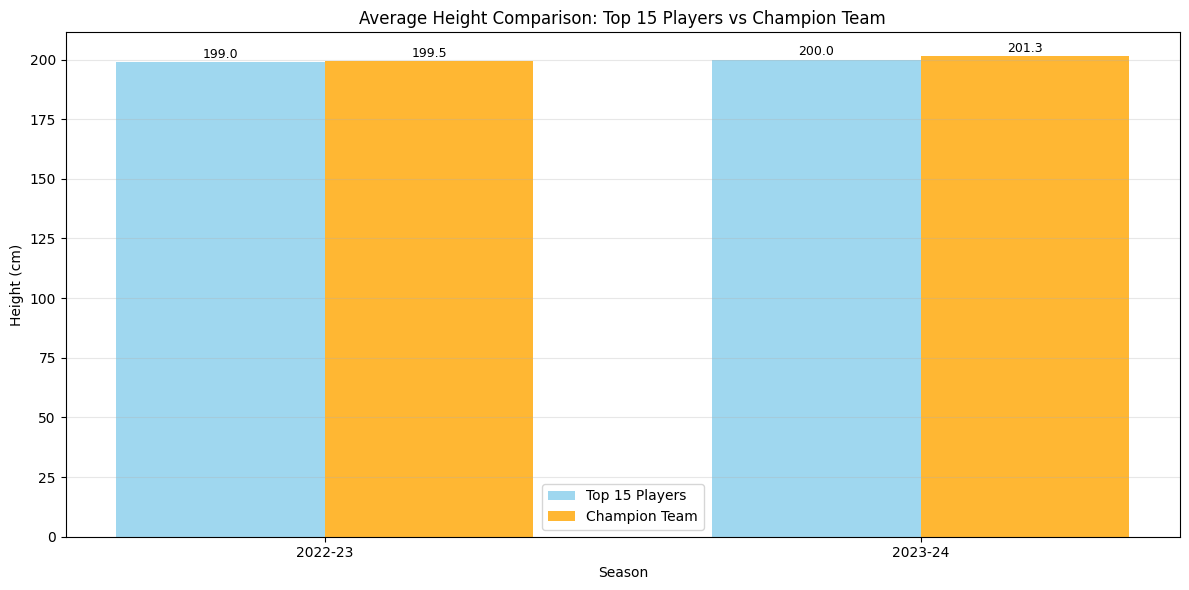

In [ ]:
seasons = top_15_players_df.index
x = np.arange(len(seasons))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, top_15_players_df['Height(cm)'], width,
               label='Top 15 Players', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, champion_teams_df['Height(cm)'], width,
               label='Champion Team', color='orange', alpha=0.8)

ax.set_xlabel('Season')
ax.set_ylabel('Height (cm)')
ax.set_title('Average Height Comparison: Top 15 Players vs Champion Team')
ax.set_xticks(x)
ax.set_xticklabels(seasons)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

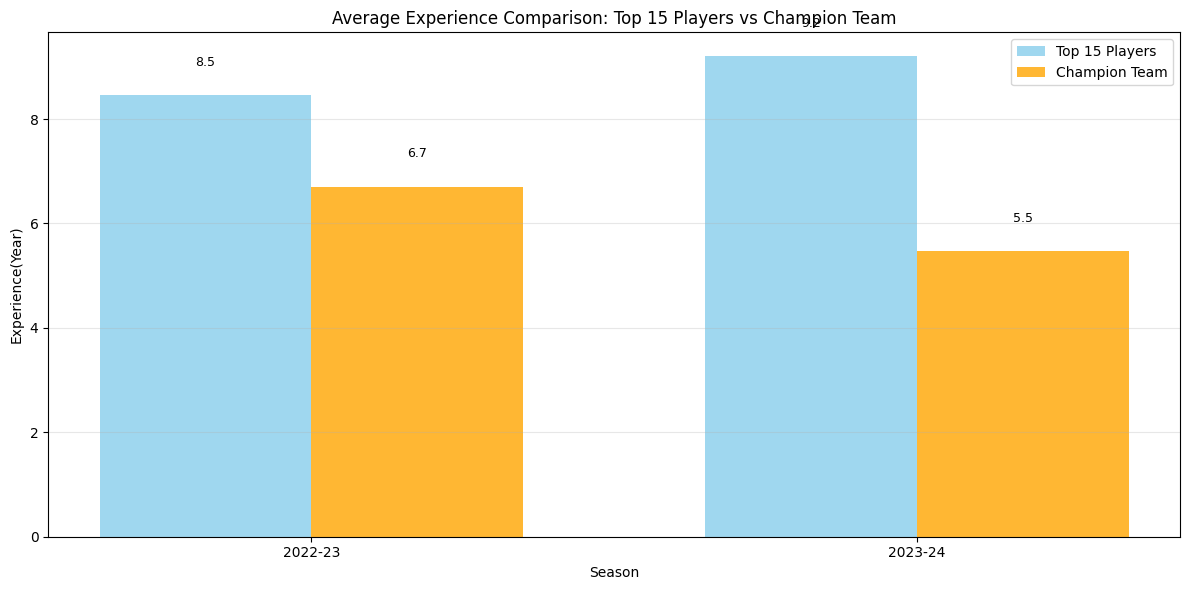

In [ ]:
seasons = top_15_players_df.index
x = np.arange(len(seasons))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, top_15_players_df['Exp'], width,
               label='Top 15 Players', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, champion_teams_df['Exp'], width,
               label='Champion Team', color='orange', alpha=0.8)

ax.set_xlabel('Season')
ax.set_ylabel('Experience(Year)')
ax.set_title('Average Experience Comparison: Top 15 Players vs Champion Team')
ax.set_xticks(x)
ax.set_xticklabels(seasons)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

####Part3

In [ ]:
m_query_5 = '''SELECT
                mvp.Player_id,
                players.Player,
                players.Pos
                FROM mvp_candidates mvp
                JOIN players on mvp.Player_id = players.id'''

mvp_candidates_df = pd.read_sql_query(m_query_5, conn)
mvp_candidates_df = mvp_candidates_df[mvp_candidates_df['Pos'] == 'PG']
mvp_candidates_df

In [ ]:
player_counts = mvp_candidates_df['Player'].value_counts().sort_values(ascending=False)
player_counts.head(5)

###Hypothesis

#### Hypothesis Number 0: Tall strikers score more goals compared to short strikers.

In [ ]:
m_query_6 = '''SELECT
                ps.player_id,
                p.Player,
                p.pos,
                s.season_label as Season,
                p.Ht,
                ps.G,
                ps.FG
                FROM player_seasons ps
                JOIN players p on p.id = ps.player_id
                JOIN seasons s on s.id = ps.season_id
                WHERE ps.Season_id BETWEEN 2 AND 6'''

h0_df = pd.read_sql_query(m_query_6, conn)
h0_df

In [ ]:
h0_df = h0_df.drop_duplicates(subset=['player_id', 'Season'], keep='first')
h0_df = h0_df[h0_df['Pos'].isin(['PG', 'SG', 'SF'])]
h0_df

In [ ]:
h0_df = h0_df[h0_df['Ht'].str.contains('-', na=False)]
h0_df['Height(cm)'] = h0_df['Ht'].apply(height_to_cm)

height_threshold = 200

h0_df['Height_Group'] = np.where(h0_df['Height(cm)'] >= height_threshold, 'Tall', 'Short')
h0_df['G'] = h0_df['G'].astype(float)
h0_df['FG'] = h0_df['FG'].astype(float)
h0_df['Total Field Goals'] = h0_df['G'] * h0_df['FG']
h0_df

,player_id,Player,Pos,Season,Ht,G,FG,Height(cm),Height_Group,Total Field Goals
0,21,Trae Young,PG,2023-24,6-1,54.0,8.0,185.42,Short,432.0
1,29,Dejounte Murray,SG,2023-24,6-5,78.0,8.6,195.58,Short,670.8
2,8,Jalen Johnson,SF,2023-24,6-9,56.0,6.4,205.74,Tall,358.4
3,22,Saddiq Bey,SF,2023-24,6-7,63.0,4.6,200.66,Tall,289.8
4,2,Bogdan Bogdanovic,SG,2023-24,6-5,79.0,6.0,195.58,Short,474.0
...,...,...,...,...,...,...,...,...,...,...
3265,127,C.J. Miles,SG,2019-20,6-6,10.0,1.9,198.12,Short,19.0
3266,596,Gary Payton II,SG,2019-20,6-2,29.0,1.7,187.96,Short,49.3
3267,1013,Jerian Grant,PG,2019-20,6-4,6.0,1.7,193.04,Short,10.2
3269,12,Garrison Mathews,SG,2019-20,6-5,18.0,1.3,195.58,Short,23.4


In [ ]:
seasonal_h0_df = h0_df.groupby(['Season', 'Height_Group'])['Total Field Goals'].sum().reset_index()
seasonal_h0_df

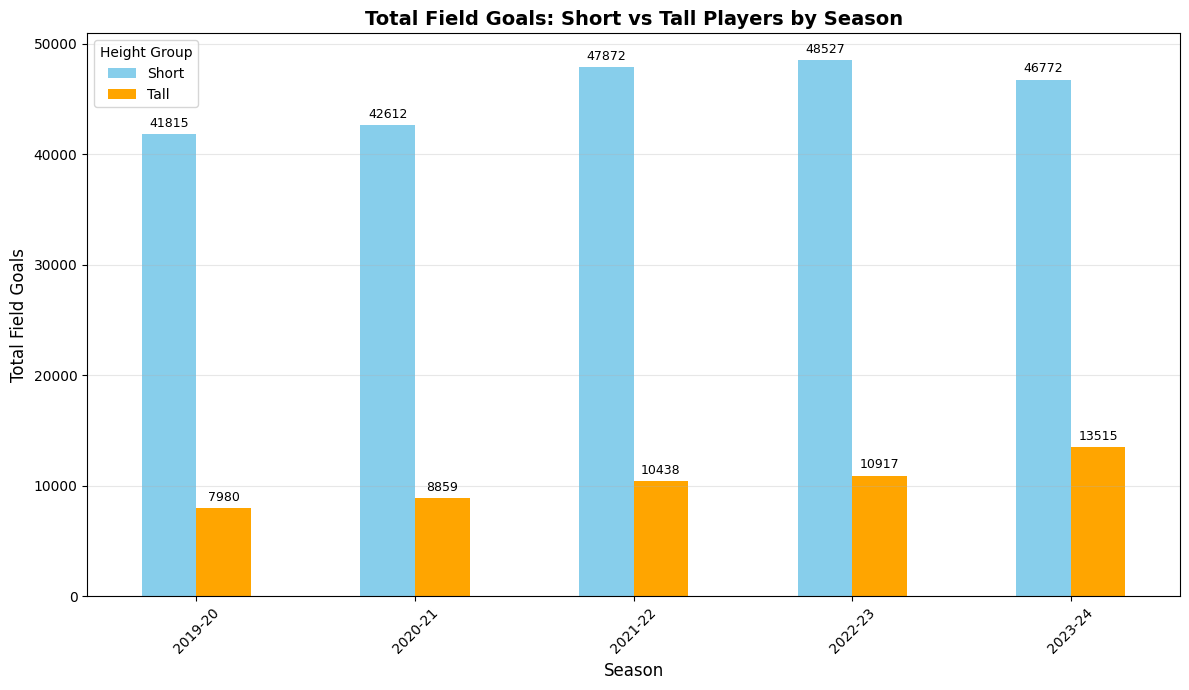

Chosen test: Mann-Whitney U test
U-statistic = 227006.50, p-value = 0.555
Short Players score more goals than Tall players.


In [ ]:
pivot_df = seasonal_h0_df.pivot(index='Season', columns='Height_Group', values='Total Field Goals')

ax = pivot_df.plot(kind='bar', figsize=(12, 7), color=['skyblue', 'orange'])
plt.title('Total Field Goals: Short vs Tall Players by Season', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Field Goals', fontsize=12)
plt.legend(title='Height Group')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

short = h0_df[h0_df['Height_Group'] == 'Short']['Total Field Goals']
tall = h0_df[h0_df['Height_Group'] == 'Tall']['Total Field Goals']

normal_short = len(short) >= 3 and stats.shapiro(short).pvalue > 0.05
normal_tall = len(tall) >= 3 and stats.shapiro(tall).pvalue > 0.05

_, levene_p = stats.levene(short, tall) # tests equality of variances
equal_var = levene_p > 0.05

if normal_short and normal_tall:
    if equal_var:
        test_name = "Student's t-test"
        t_stat, p_val = stats.ttest_ind(tall, short, equal_var=True, alternative='greater')
    else:
        test_name = "Welch's t-test"
        t_stat, p_val = stats.ttest_ind(tall, short, equal_var=False, alternative='greater')
    print(f"Chosen test: {test_name}")
    print(f"t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")
else:
    test_name = "Mann-Whitney U test"
    u_stat, p_val = stats.mannwhitneyu(tall, short, alternative='greater')
    print(f"Chosen test: {test_name}")
    print(f"U-statistic = {u_stat:.2f}, p-value = {p_val:.3f}")

if p_val < 0.05:
  print('Tall Players score more goals than Short players.')
else:
  print('Short Players score more goals than Tall players.')

#### Hypothesis Number 1

In [ ]:
m_query_7 = '''SELECT
                ps.player_id,
                p.player,
                s.season_label as Season,
                p.Ht,
                p.Wt,
                ps.G,
                ps.PTS
                FROM player_seasons ps
                JOIN players p on p.id = ps.player_id
                JOIN seasons s on s.id = ps.season_id
                WHERE ps.Season_id BETWEEN 2 AND 5'''

h1_df = pd.read_sql_query(m_query_7, conn)
h1_df = h1_df.drop_duplicates(subset=['player_id', 'Season'], keep='first')
h1_df = h1_df[h1_df['Ht'].str.contains('-', na=False)]
h1_df['Height(cm)'] = h1_df['Ht'].apply(height_to_cm)
h1_df['Wt'] = h1_df['Wt'].astype(float)

h1s_df = h1_df[h1_df['G'].apply(lambda x: str(x).replace('.', '').isdigit())]
h1_df['Total PTS'] = h1_df['PTS'].astype(float) * h1_df['G'].astype(float)

h1_df['Agility'] = h1_df['Height(cm)'] / h1_df['Wt']
h1_df = h1_df.sort_values(by=['Season', 'Total PTS'], ascending=[True, False])
h1_df = h1_df.groupby('Season').head(20)
h1_df

,player_id,Player,Season,Ht,Wt,G,PTS,Height(cm),Total PTS,Agility
861,588,Stephen Curry,2020-21,6-2,185.0,63,32.0,187.96,2016.0,1.016000
2193,854,Damian Lillard,2020-21,6-2,195.0,67,28.8,187.96,1929.6,0.963897
675,483,Nikola Jokic,2020-21,6-11,284.0,72,26.4,210.82,1900.8,0.742324
2663,1039,Bradley Beal,2020-21,6-4,207.0,60,31.3,193.04,1878.0,0.932560
598,429,Luka Doncic,2020-21,6-6,230.0,66,27.7,198.12,1828.2,0.861391
...,...,...,...,...,...,...,...,...,...,...
1846,989,Paolo Banchero,2023-24,6-10,250.0,80,22.6,208.28,1808.0,0.833120
1414,854,Damian Lillard,2023-24,6-2,195.0,73,24.3,187.96,1773.9,0.963897
1,29,Dejounte Murray,2023-24,6-5,180.0,78,22.5,195.58,1755.0,1.086556
1060,731,Paul George,2023-24,6-8,220.0,74,22.6,203.20,1672.4,0.923636


In [ ]:
seasonal_h1_df = h1_df.groupby('Season')['Agility'].mean().reset_index()
seasonal_h1_df

,Season,Agility
0,2020-21,0.930151
1,2021-22,0.917787
2,2022-23,0.926060
3,2023-24,0.917589


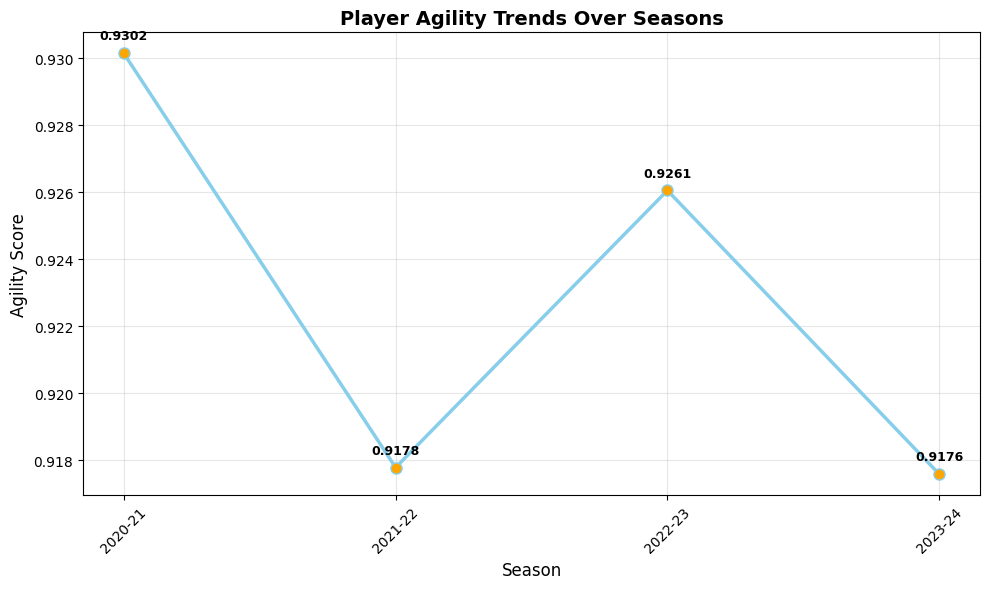

Chosen test: Mann-Whitney U test
U-statistic = 1.00, p-value = 0.833
Fail to reject null Hypothesis. Agility hasn't increased


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(seasonal_h1_df['Season'], seasonal_h1_df['Agility'], marker='o', linewidth=2.5, markersize=8,
         color='skyblue', markerfacecolor='orange')

plt.title('Player Agility Trends Over Seasons', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Agility Score', fontsize=12)
plt.grid(True, alpha=0.3)

for i, (season, agility) in enumerate(zip(seasonal_h1_df['Season'], seasonal_h1_df['Agility'])):
    plt.annotate(f'{agility:.4f}', (season, agility),
                 textcoords="offset points", xytext=(0,10),
                 ha='center', fontsize=9, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

warnings.filterwarnings("ignore", message="divide by zero encountered in scalar divide", category=RuntimeWarning)

old_seasons = seasonal_h1_df[seasonal_h1_df['Season'].isin(['2020-21', '2021-22'])]['Agility']
new_seasons = seasonal_h1_df[seasonal_h1_df['Season'].isin(['2022-23', '2023-24'])]['Agility']

normal_previous = len(old_seasons) >= 3 and stats.shapiro(old_seasons).pvalue > 0.05
normal_recent = len(new_seasons) >= 3 and stats.shapiro(new_seasons).pvalue > 0.05

if len(old_seasons) > 1 and len(new_seasons) > 1:
    _, levene_p = stats.levene(old_seasons, new_seasons)
    equal_var = levene_p > 0.05
else:
    equal_var = False

if normal_previous and normal_recent:
    if equal_var:
        test_name = "Student's t-test"
        t_stat, p_val = stats.ttest_ind(new_seasons, old_seasons, equal_var=True, alternative='greater')
    else:
        test_name = "Welch's t-test"
        t_stat, p_val = stats.ttest_ind(new_seasons, old_seasons, equal_var=False, alternative='greater')
    print(f"Chosen test: {test_name}")
    print(f"t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")
else:
    test_name = "Mann-Whitney U test"
    u_stat, p_val = stats.mannwhitneyu(new_seasons, old_seasons, alternative='greater')
    print(f"Chosen test: {test_name}")
    print(f"U-statistic = {u_stat:.2f}, p-value = {p_val:.3f}")

if p_val < 0.05:
  print('Agility has increased.')
else:
  print("Fail to reject null Hypothesis. Agility hasn't increased")

#### Hypothesis Number 2

In [ ]:
m_query_8 = '''SELECT
                ps.player_id,
                p.player,
                s.season_label as Season,
                p.[Birth Date],
                ps.Exp,
                t.team_name,
                s.[League Champion]
                FROM player_seasons ps
                JOIN players p on p.id = ps.player_id
                JOIN seasons s on s.id = ps.season_id
                JOIN teams t on t.id = ps.team_id
                WHERE ps.Season_id BETWEEN 1 AND 4;
            '''

h2_df = pd.read_sql_query(m_query_8, conn)
h2_df = h2_df.drop_duplicates(subset=['player_id', 'Season'], keep='first')
h2_df = h2_df[h2_df['League Champion'] == h2_df['team_name']]
h2_df['Birth Year'] = h2_df['Birth Date'].str.split(' ').str[2]
h2_df['Age'] = h2_df['Season'].str.split('-').str[0].astype(int) - h2_df['Birth Year'].astype(int)
h2_df = h2_df[h2_df['Exp'] != 'R']
h2_df['Exp'] = h2_df['Exp'].astype(float)
h2_df = h2_df[['player_id', 'Player', 'Season', 'Age', 'Exp']]

h2_df['Natural talent'] = h2_df['Exp'] / h2_df['Age']

h2_df = h2_df[['player_id', 'Player', 'Season', 'Age', 'Exp', 'Natural talent']]
h2_df

,player_id,Player,Season,Age,Exp,Natural talent
105,103,Jayson Tatum,2023-24,25,7.0,0.280000
106,89,Jaylen Brown,2023-24,27,8.0,0.296296
107,93,Jrue Holiday,2023-24,33,15.0,0.454545
108,106,Derrick White,2023-24,29,7.0,0.241379
109,98,Kristaps Porzingis,2023-24,28,8.0,0.285714
...,...,...,...,...,...,...
1810,332,Alex Caruso,2024-25,30,6.0,0.200000
1811,966,Jaylin Williams,2024-25,22,2.0,0.090909
1814,924,Kenrich Williams,2024-25,30,1.0,0.033333
1815,953,Ousmane Dieng,2024-25,21,2.0,0.095238


In [ ]:
seasonal_h2_df = h2_df.groupby('Season')['Natural talent'].mean().reset_index()
seasonal_h2_df

,Season,Natural talent
0,2021-22,0.247106
1,2022-23,0.235186
2,2023-24,0.195677
3,2024-25,0.099703


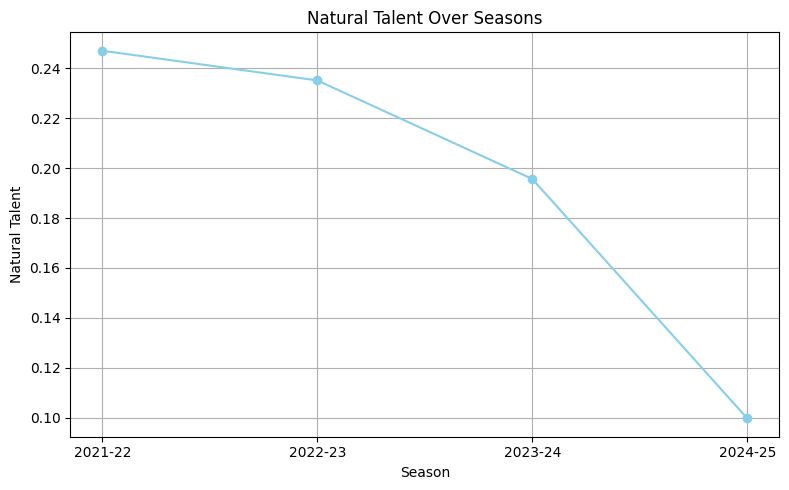

U-statistic: 321.0000
p-value: 0.9949
Natural talent is lower in recent games.


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(seasonal_h2_df['Season'], seasonal_h2_df['Natural talent'], marker='o', linestyle='-', color='skyblue')
plt.title('Natural Talent Over Seasons')
plt.xlabel('Season')
plt.ylabel('Natural Talent')
plt.grid(True)
plt.tight_layout()
plt.show()

new_seasons = h2_df[h2_df['Season'].isin(['2023-24', '2024-25'])]['Natural talent']
old_seasons = h2_df[h2_df['Season'].isin(['2021-22', '2022-23'])]['Natural talent']


if len(old_seasons) < 3 or len(new_seasons) < 3:
    use_parametric = False
else:
    shapiro_new = stats.shapiro(new_seasons)
    shapiro_old = stats.shapiro(old_seasons)
    use_parametric = (shapiro_new.pvalue >= 0.05) and (shapiro_old.pvalue >= 0.05)

if use_parametric:
    t_stat, p_value = stats.ttest_ind(new_seasons, old_seasons, alternative='greater', equal_var=False)
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
else:
    u_stat, p_value = stats.mannwhitneyu(new_seasons, old_seasons, alternative='greater')
    print(f"U-statistic: {u_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"Reject null hypothesis: Natural talent is higher in recent seasons.")
else:
    print(f"Natural talent is lower in recent games.")

## **Statistical charts** (niloufar)

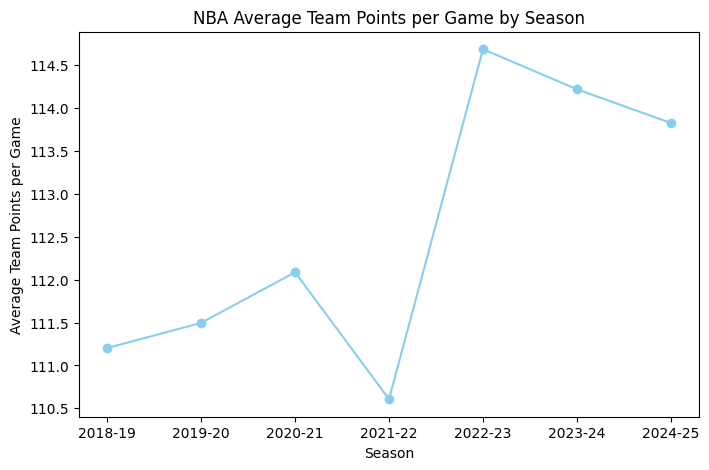

In [ ]:
query1 = '''SELECT * FROM team_seasons;'''
query2 = '''SELECT * FROM seasons;'''
team_seasons = pd.read_sql_query(query1, conn)
seasons = pd.read_sql_query(query2, conn)

team_seasons_cp = team_seasons.copy()

team_seasons_cp= team_seasons.merge(seasons, how='inner', left_on='season_id', right_on='id')
pts_per_game = team_seasons_cp.groupby("season_label",as_index=False)['PTS/G'].mean().reset_index()
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
# ax.bar(pts_per_game['season_label'],pts_per_game['PTS/G'])
ax.plot(pts_per_game['season_label'],pts_per_game['PTS/G'], marker='o',color='skyblue')
ax.set_xlabel('Season')
ax.set_ylabel('Average Team Points per Game')
ax.set_title('NBA Average Team Points per Game by Season')
# ax.set_ylim(100,115)
plt.show()

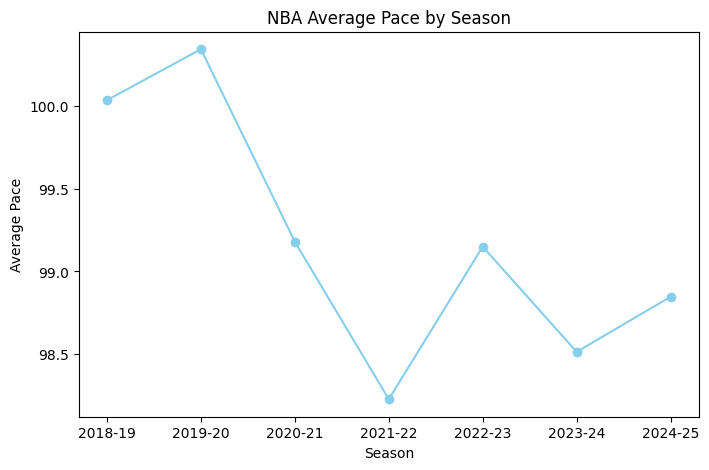

In [ ]:
pace_per_season = team_seasons_cp.groupby("season_label",as_index=False)['Pace'].mean().reset_index()
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
ax.plot(pace_per_season['season_label'],pace_per_season['Pace'], marker='o',color='skyblue')
ax.set_xlabel('Season')
ax.set_ylabel('Average Pace')
ax.set_title('NBA Average Pace by Season')
plt.show()

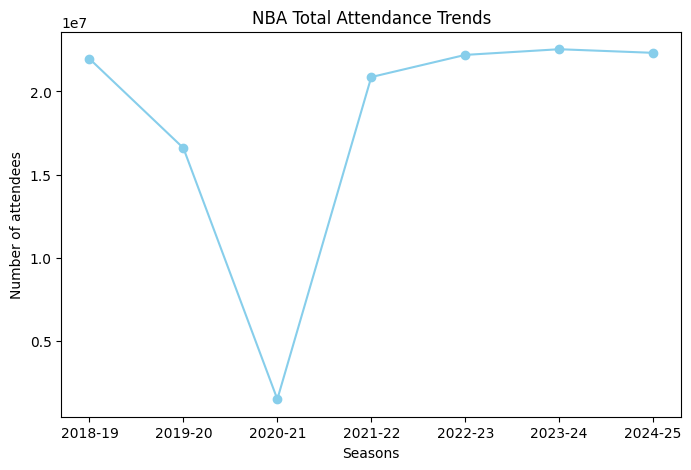

In [ ]:
attendace_per_season = team_seasons_cp.groupby("season_label",as_index=False)['attendace_total'].sum().reset_index()
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
# ax.bar(attendace_per_season['season_label'],attendace_per_season['attendace_total'])
ax.plot(attendace_per_season['season_label'],attendace_per_season['attendace_total'], marker='o',color='skyblue')
ax.set_xlabel('Seasons')
ax.set_ylabel('Number of attendees')
ax.set_title('NBA Total Attendance Trends')
plt.show()


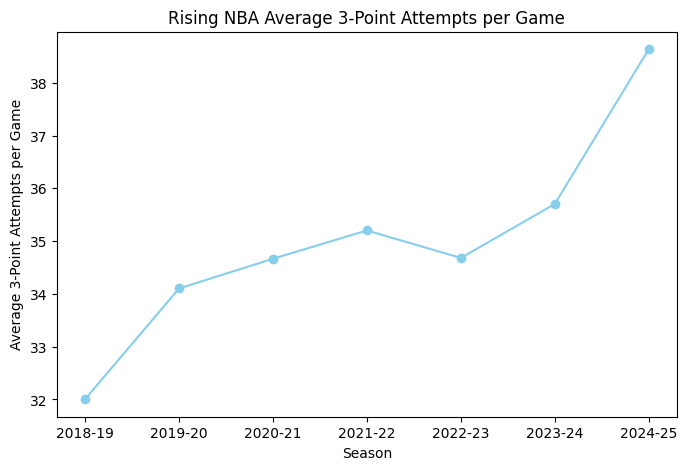

In [ ]:
query3 = '''SELECT * FROM Player_Seasons;'''
player_seasons = pd.read_sql_query(query3, conn)

player_seasons_cp = player_seasons.copy()
team_seasons_cp = team_seasons.copy()

team_seasons_cp= team_seasons.merge(seasons, how='inner', left_on='season_id', right_on='id')

player_seasons_cp['3PA'] = pd.to_numeric(player_seasons_cp['3PA'], errors='coerce')
player_seasons_cp['G'] = pd.to_numeric(player_seasons_cp['G'], errors='coerce')
player_seasons_cp['tmp'] = player_seasons_cp['3PA']*player_seasons_cp['G']
df = player_seasons_cp.groupby(['team_id','season_id'],as_index=False)['tmp'].sum().reset_index()
team_seasons_cp = team_seasons_cp.merge(df, how='inner', left_on=['team_id','season_id'], right_on=['team_id','season_id'])
team_seasons_cp['team_games'] = team_seasons_cp['wins'] + team_seasons_cp['losses']
# team_seasons_cp['3PA/G'] = team_seasons_cp['tmp']/82
team_seasons_cp['3PA/G'] = team_seasons_cp['tmp']/team_seasons_cp['team_games']
three_pa_per_game = team_seasons_cp.groupby("season_label",as_index=False)['3PA/G'].mean().reset_index()
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
# ax.bar(three_pa_per_game['season_label'],three_pa_per_game['3PA/G'])
ax.plot(three_pa_per_game['season_label'],three_pa_per_game['3PA/G'], marker='o',color = 'skyblue')
ax.set_xlabel('Season')
ax.set_ylabel('Average 3-Point Attempts per Game')
ax.set_title('Rising NBA Average 3-Point Attempts per Game')
plt.show()

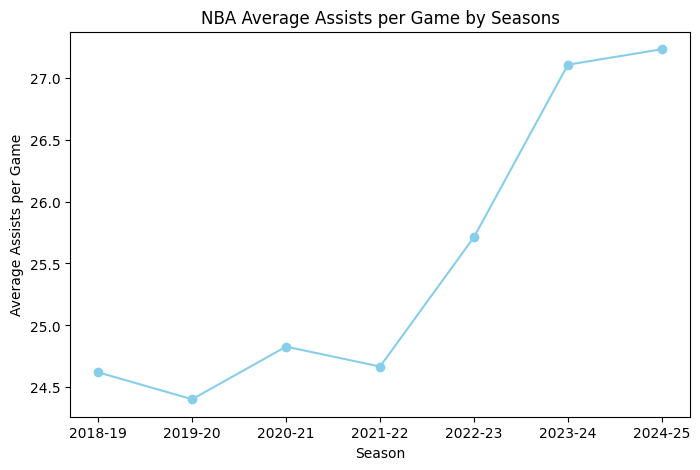

In [ ]:
player_seasons_cp = player_seasons.copy()
team_seasons_cp = team_seasons.copy()

team_seasons_cp= team_seasons.merge(seasons, how='inner', left_on='season_id', right_on='id')

player_seasons_cp['AST'] = pd.to_numeric(player_seasons_cp['AST'], errors='coerce')
player_seasons_cp['G'] = pd.to_numeric(player_seasons_cp['G'], errors='coerce')
player_seasons_cp['tmp'] = player_seasons_cp['AST']*player_seasons_cp['G']
df = player_seasons_cp.groupby(['team_id','season_id'],as_index=False)['tmp'].sum().reset_index()
team_seasons_cp = team_seasons_cp.merge(df, how='inner', left_on=['team_id','season_id'], right_on=['team_id','season_id'])
team_seasons_cp['team_games'] = team_seasons_cp['wins'] + team_seasons_cp['losses']
# team_seasons_cp['AST/G'] = team_seasons_cp['tmp']/82
team_seasons_cp['AST/G'] = team_seasons_cp['tmp']/team_seasons_cp['team_games']
ast_per_game = team_seasons_cp.groupby("season_label",as_index=False)['AST/G'].mean().reset_index()
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
# ax.bar(three_pa_per_game['season_label'],three_pa_per_game['AST/G'])
ax.plot(ast_per_game['season_label'],ast_per_game['AST/G'], marker='o',color='skyblue')
ax.set_xlabel('Season')
ax.set_ylabel('Average Assists per Game')
ax.set_title('NBA Average Assists per Game by Seasons')
plt.show()


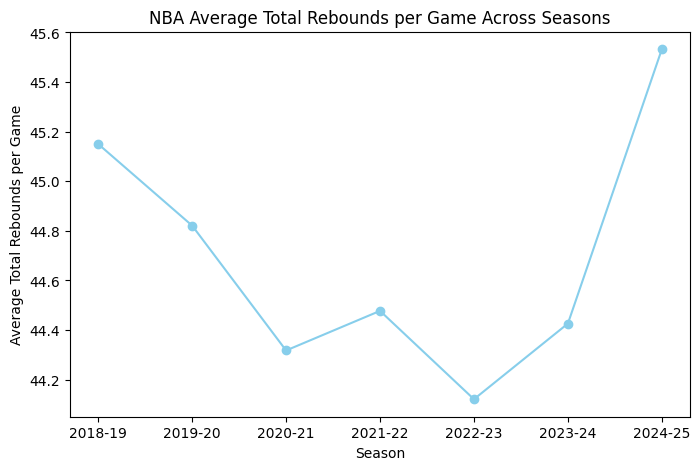

In [ ]:
player_seasons_cp = player_seasons.copy()
team_seasons_cp = team_seasons.copy()

team_seasons_cp= team_seasons.merge(seasons, how='inner', left_on='season_id', right_on='id')

player_seasons_cp['TRB'] = pd.to_numeric(player_seasons_cp['TRB'], errors='coerce')
player_seasons_cp['G'] = pd.to_numeric(player_seasons_cp['G'], errors='coerce')
player_seasons_cp['tmp'] = player_seasons_cp['TRB']*player_seasons_cp['G']
df = player_seasons_cp.groupby(['team_id','season_id'],as_index=False)['tmp'].sum().reset_index()
team_seasons_cp = team_seasons_cp.merge(df, how='inner', left_on=['team_id','season_id'], right_on=['team_id','season_id'])
team_seasons_cp['team_games'] = team_seasons_cp['wins'] + team_seasons_cp['losses']
# team_seasons_cp['TRB/G'] = team_seasons_cp['tmp']/82
team_seasons_cp['TRB/G'] = team_seasons_cp['tmp']/team_seasons_cp['team_games']
trb_per_game = team_seasons_cp.groupby("season_label",as_index=False)['TRB/G'].mean().reset_index()
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
# ax.bar(three_pa_per_game['season_label'],three_pa_per_game['AST/G'])
ax.plot(trb_per_game['season_label'],trb_per_game['TRB/G'], marker='o',color='skyblue')
ax.set_xlabel('Season')
ax.set_ylabel('Average Total Rebounds per Game')
ax.set_title('NBA Average Total Rebounds per Game Across Seasons')
plt.show()


   index Pos       PTS
2      2  PG  9.710608
1      1  PF  8.557803
4      4  SF  8.190263
5      5  SG  7.947335
0      0   C  7.727343


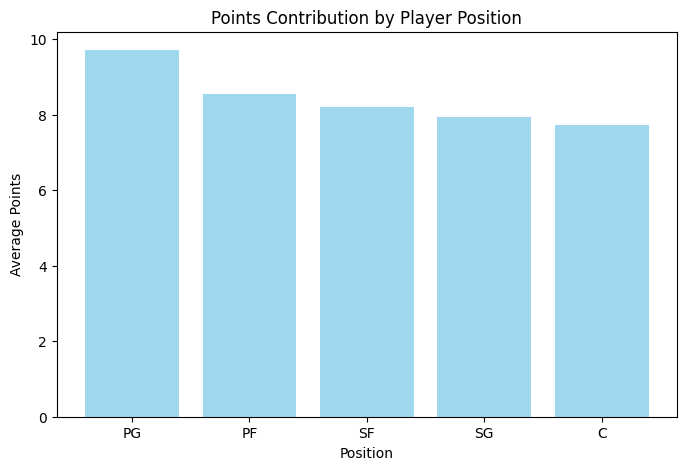

In [ ]:
query4 = '''SELECT * FROM Players;'''
players = pd.read_sql_query(query4, conn)

player_seasons_cp = player_seasons.copy()
players_cp = players.copy()

player_seasons_cp= player_seasons_cp.merge(players, how='inner', left_on='player_id', right_on='id')

player_seasons_cp['PTS'] = pd.to_numeric(player_seasons_cp['PTS'], errors='coerce')
pts_per_pos= player_seasons_cp.groupby("Pos",as_index=False)['PTS'].mean().reset_index().dropna()
pts_per_pos = pts_per_pos.sort_values('PTS',ascending=False)
print(pts_per_pos)

fig , ax = plt.subplots(1, 1, figsize = (8, 5))
ax.bar(pts_per_pos['Pos'],pts_per_pos['PTS'],color='skyblue',alpha=0.8)
ax.set_xlabel('Position')
ax.set_ylabel('Average Points')
ax.set_title('Points Contribution by Player Position')
plt.show()


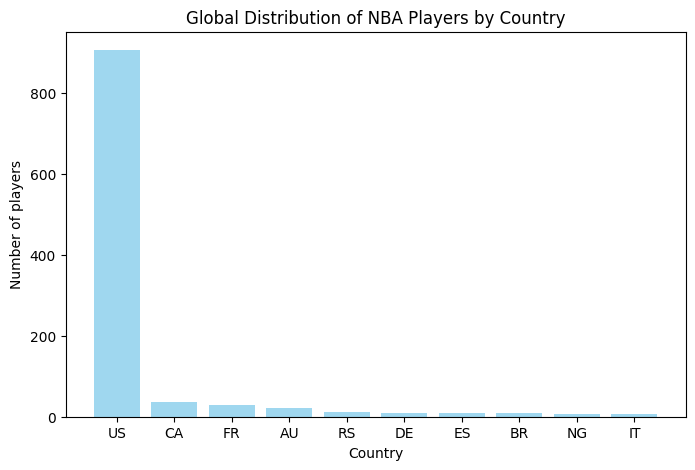

In [ ]:
players_cp = players.copy()
players_cp['Birth'] = players_cp['Birth'].str.split(' ').str[1]
df= players_cp.groupby("Birth",as_index=False)['id'].count().reset_index().dropna()
df = df.sort_values('id',ascending=False)
df = df.head(10)
fig , ax = plt.subplots(1, 1, figsize = (8, 5))
ax.bar(df['Birth'],df['id'],color='skyblue',alpha=0.8)
ax.set_xlabel('Country')
ax.set_ylabel('Number of players')
ax.set_title('Global Distribution of NBA Players by Country')
plt.show()


   index Pos       AST
2      2  PG  3.597139
5      5  SG  1.809304
1      1  PF  1.534104
4      4  SF  1.529439
0      0   C  1.244983


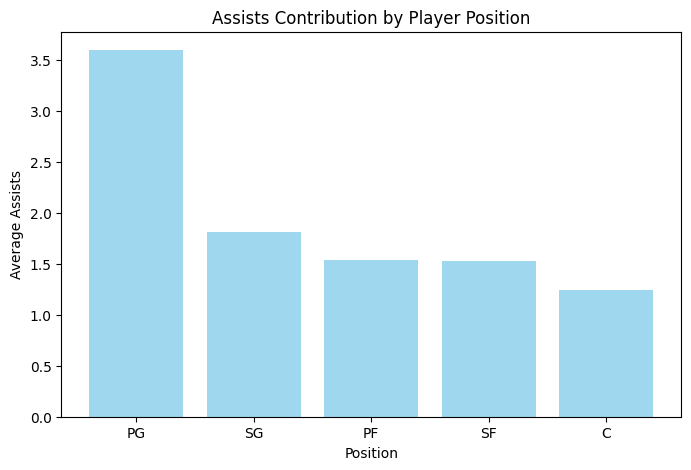

In [ ]:
player_seasons_cp = player_seasons.copy()
players_cp = players.copy()

player_seasons_cp= player_seasons_cp.merge(players, how='inner', left_on='player_id', right_on='id')

player_seasons_cp['AST'] = pd.to_numeric(player_seasons_cp['AST'], errors='coerce')
ast_per_pos= player_seasons_cp.groupby("Pos",as_index=False)['AST'].mean().reset_index().dropna()
ast_per_pos = ast_per_pos.sort_values('AST',ascending=False)
print(ast_per_pos)

fig , ax = plt.subplots(1, 1, figsize = (8, 5))
ax.bar(ast_per_pos['Pos'],ast_per_pos['AST'],color='skyblue',alpha=0.8)
ax.set_xlabel('Position')
ax.set_ylabel('Average Assists')
ax.set_title('Assists Contribution by Player Position')
plt.show()


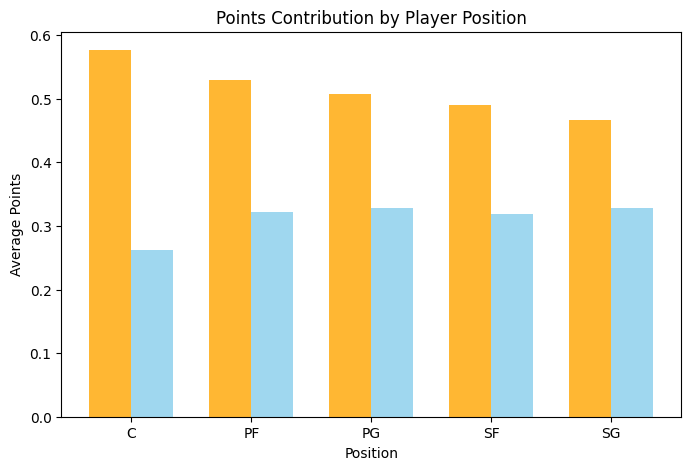

In [ ]:
player_seasons_cp = player_seasons.copy()
players_cp = players.copy()

player_seasons_cp= player_seasons_cp.merge(players, how='inner', left_on='player_id', right_on='id')

player_seasons_cp['3P%'] = pd.to_numeric(player_seasons_cp['3P%'], errors='coerce')
three_p_per_pos= player_seasons_cp.groupby("Pos",as_index=False)['3P%'].mean().reset_index().dropna()

player_seasons_cp['2P%'] = pd.to_numeric(player_seasons_cp['2P%'], errors='coerce')
two_p_per_pos= player_seasons_cp.groupby("Pos",as_index=False)['2P%'].mean().reset_index().dropna()
# three_p_per_pos = three_p_per_pos.sort_values('3P%',ascending=False)
two_p_per_pos = two_p_per_pos.sort_values('2P%',ascending=False)

fig , ax = plt.subplots(1, 1, figsize = (8, 5))
positions = np.arange(len(three_p_per_pos['Pos']))
width = 0.35
ax.bar(positions + width/2, three_p_per_pos['3P%'], width, color='skyblue', alpha=0.8, label='3P%')
ax.bar(positions - width/2, two_p_per_pos['2P%'], width, color='orange', alpha=0.8, label='2P%')
ax.set_xticks(positions)
ax.set_xticklabels(three_p_per_pos['Pos'])
ax.set_xlabel('Position')
ax.set_ylabel('Average Points')
ax.set_title('Points Contribution by Player Position')
plt.show()

##Ali (Additional Hypothsis)

**H1 : players who win MVP play in Teams that have highter %NetRtg**

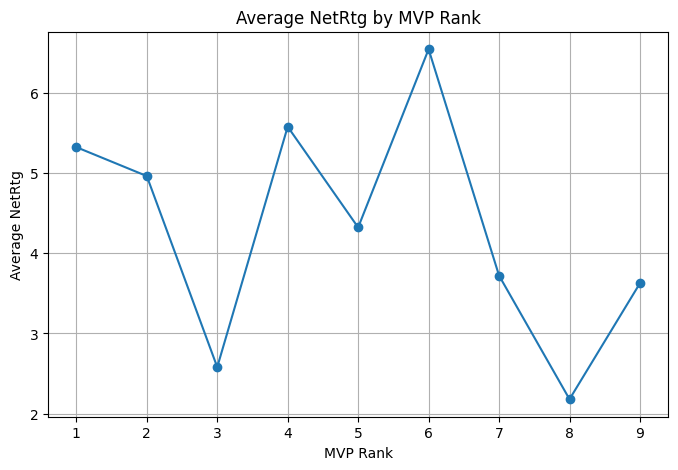

            Rank    NetRtg
Rank    1.000000 -0.378991
NetRtg -0.378991  1.000000

 -- p_value and U are 0.596 and 47.0 so that is Not significant --


In [ ]:
query = '''SELECT
  sn.season_label,p.Player,ts.NetRtg, mc.Rank
FROM mvp_candidates mc
JOIN players p
  ON p.id = mc.Player_id
JOIN teams t
  ON t.team_code = mc.Tm
join seasons sn
    ON mc.season_id = sn.id
JOIN team_seasons ts
    ON ts.team_id = t.id
    AND ts.season_id = mc.Season_id
    WHERE mc.Rank in ('1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9')

ORDER BY mc.season_id;'''
df = pd.read_sql_query(query, conn)
df['NetRtg'] = pd.to_numeric(df['NetRtg'], errors='coerce')

df_grouped = df.groupby('Rank')['NetRtg'].mean().reset_index()
df_grouped['Rank'] = pd.to_numeric(df_grouped['Rank'])

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(df_grouped['Rank'], df_grouped['NetRtg'], marker='o')

ax.set_xlabel('MVP Rank')
ax.set_ylabel('Average NetRtg')
ax.set_title('Average NetRtg by MVP Rank')
ax.grid(True)

plt.show()

print(df_grouped.corr())

statistic, p_value = stats.mannwhitneyu(df_grouped['Rank'], df_grouped['NetRtg'])
if p_value < 0.05:
  print(f'\n --p_value and U are {p_value} and {statistic} so that is significant--')
else:
  print(f'\n -- p_value and U are {p_value:.3} and {statistic} so that is Not significant --')

**H2 : when team plays with more pace, hava more spectators**



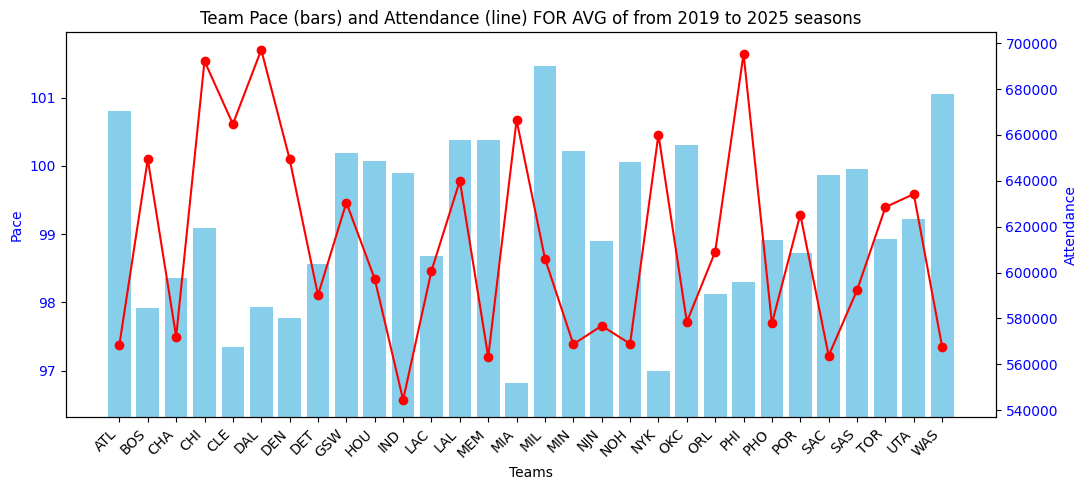


 -- p_value and U are 0.83 and 435.0 so that is Not significant --


In [ ]:
query = '''SELECT tm.team_code as teams,
AVG(ts.Pace) as Pace,
AVG(ts.attendace_total) as ATT,
avg(ts.championship_odds) as 'Ch_odd'
from team_seasons ts
join teams tm on ts.team_id = tm.id
group by tm.team_code;'''
df = pd.read_sql_query(query, conn)
df['Pace'] = pd.to_numeric(df['Pace'], errors='coerce')
df['ATT'] = pd.to_numeric(df['ATT'], errors='coerce')
df['Ch_odd'] = pd.to_numeric(df['Ch_odd'], errors='coerce')

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.bar(df['teams'], df['Pace'], color='skyblue', label='Pace')
ax1.set_ylabel('Pace', color='blue')
min_pace = df['Pace'].min()
max_pace = df['Pace'].max()
ax1.set_ylim(min_pace - 0.5, max_pace + 0.5)
ax1.set_xlabel('Teams')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(df['teams'])))
ax1.set_xticklabels(df['teams'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(df['teams'], df['ATT'], color='red', marker='o', label='Attendance')
ax2.set_ylabel('Attendance', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Team Pace (bars) and Attendance (line) FOR AVG of from 2019 to 2025 seasons")
plt.show()

''' # be dalil meghyas motafavet P_value dorost nabod
statistic, p_value = stats.mannwhitneyu(df['ATT'], df['Pace'])
if p_value < 0.05:
  print(f'\n --p_value and U are {p_value:.3} and {statistic} so that is significant--')
else:
  print(f'\n -- p_value and U are {p_value:.3} and {statistic} so that is Not significant --')
'''
df_test = df.copy()

df_test['Pace_z'] = (df['Pace'] - df['Pace'].mean()) / df['Pace'].std()
df_test['ATT_z'] = (df['ATT'] - df['ATT'].mean()) / df['ATT'].std()

statistic, p_value = stats.mannwhitneyu(df_test['ATT_z'], df_test['Pace_z'])
if p_value < 0.05:
  print(f'\n --p_value and U are {p_value:.3} and {statistic} so that is significant--')
else:
  print(f'\n -- p_value and U are {p_value:.3} and {statistic} so that is Not significant --')

**H3 : When people bet on a team with a higher risk factor, it has more spectators.**


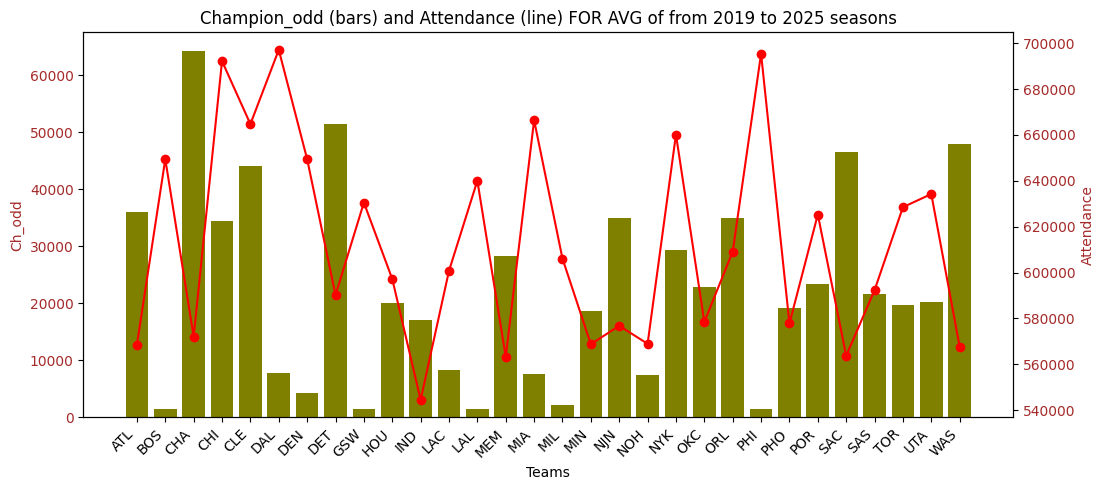


 -- p_value and U are 0.935 and 456.0 so that is Not significant --


In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.bar(df['teams'], df['Ch_odd'], color='olive', label='Pace')
ax1.set_ylabel('Ch_odd', color='brown')
ax1.set_xlabel('Teams')
ax1.tick_params(axis='y', labelcolor='brown')
ax1.set_xticks(range(len(df['teams'])))
ax1.set_xticklabels(df['teams'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(df['teams'], df['ATT'], color='red', marker='o', label='Attendance')
ax2.set_ylabel('Attendance', color='brown')
ax2.tick_params(axis='y', labelcolor='brown')

plt.title("Champion_odd (bars) and Attendance (line) FOR AVG of from 2019 to 2025 seasons")
plt.show()

''' # be dalil meghyas motafavet P_value dorost nabod
statistic, p_value = stats.mannwhitneyu(df['ATT'], df['Ch_odd'])
if p_value < 0.05:
  print(f'\n --p_value and U are {p_value:.3} and {statistic} so that is significant--')
else:
  print(f'\n -- p_value and U are {p_value:.3} and {statistic} so that is Not significant --')'''

df_test = df.copy()

df_test['Ch_odd_z'] = (df['Ch_odd'] - df['Ch_odd'].mean()) / df['Ch_odd'].std()
df_test['ATT_z'] = (df['ATT'] - df['ATT'].mean()) / df['ATT'].std()

statistic, p_value = stats.mannwhitneyu(df_test['ATT_z'], df_test['Ch_odd_z'])
if p_value < 0.05:
  print(f'\n --p_value and U are {p_value:.3} and {statistic} so that is significant--')
else:
  print(f'\n -- p_value and U are {p_value:.3} and {statistic} so that is Not significant --')
